In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport src

In [14]:
cd ..

/home/mars/src_aiai


In [22]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from src.data import load_M51
from src.operators.measurement import NUFFT_op #, MeasurementOperatorDiscrete
from src.operators.dictionary import wavelet_basis #, MeasurementOperatorDiscrete

from src.sampling.uv_sampling import spider_sampling # RadialSampling, SpiderSampling, SpiderSampling2
from src.solvers import PrimalDual_l1_constrained

imshow_kwargs = {"cmap":'afmhot', "origin":'lower'}

In [15]:
x_true = load_M51()

In [18]:
Nd=(256,256) # input image size 
Kd=(512,512) # oversampled k-space size
Jd=(6,6) # interpolation kernel size

vis = spider_sampling() # using Duncan et al. configuration

op_nufft8 = NUFFT_op()
op_nufft8.plan(vis, Nd, Kd, (8,8)) # for measurements
op_nufft4 = NUFFT_op()
op_nufft4.plan(vis, Nd, Kd, (4,4)) # for reconstruction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4440/4440 [00:01<00:00, 4250.72it/s]


## Generating noisy data

In [19]:
y = op_nufft8.dir_op(x_true) # measurements using J=8

In [20]:
# creating noisy data
ISNR = 30 # very low noise
sigma = np.linalg.norm(y, ord=2)/ np.sqrt(len(y)) * 10**(- ISNR/20)

noisy_y = y + np.random.randn(len(y))*np.exp(1j* np.random.random()*2*np.pi )*sigma


Text(0.5, 1.0, 'difference w/ and w/o noise')

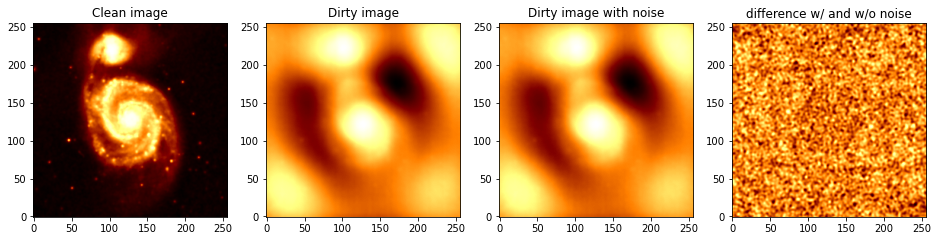

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
ax[0].imshow(x_true, **imshow_kwargs)
ax[0].set_title("Clean image")
ax[1].imshow(op_nufft4.adj_op(y).real, **imshow_kwargs)
ax[1].set_title("Dirty image")
ax[2].imshow(op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[2].set_title("Dirty image with noise")
ax[3].imshow(op_nufft4.adj_op(y).real - op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[3].set_title("difference w/ and w/o noise")


## solving with constrained solver

In [25]:
psi = wavelet_basis(x_true.shape)
solver = PrimalDual_l1_constrained(op_nufft4, psi)


{'tol': 1e-05, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': True, 'real': True}


In [26]:
result, diag = solver.solve(noisy_y, op_nufft4, sigma)

2021-10-21 11:57:08,275 - Optimus Primal - INFO - Starting Power method
2021-10-21 11:57:08,422 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-10-21 11:57:09,172 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-10-21 11:57:09,250 - Optimus Primal - INFO - [Power Method] Converged with norm= 5.703382277798678, iter = 12, tol = 0.0009171757931470651
2021-10-21 11:57:09,367 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-10-21 11:57:09,583 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.629383
2021-10-21 11:57:18,851 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.014215
2021-10-21 11:57:28,005 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.007391
2021-10-21 11:57:37,070 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.004403
2021-10-21 11:57:46,274 - Optimus Primal - INFO - [Primal Dual] 200 out of 5000 iterations, tol = 0.0

(array([[3264.35696697, 3249.16023502, 3217.44427133, ..., 3105.18277091,
         3217.8945892 , 3216.22240777],
        [3265.35882631, 3248.03291361, 3255.06050102, ..., 3132.51501771,
         3239.59771985, 3239.60675281],
        [3227.19750103, 3214.35057837, 3210.53132832, ..., 3097.58738111,
         3202.15810484, 3241.34592487],
        ...,
        [3182.40068336, 3086.37493861, 2922.24689946, ..., 3496.18984418,
         3454.08980637, 3444.82773934],
        [3020.18436226, 3016.24362251, 3009.86517712, ..., 3487.00683386,
         3460.51509353, 3422.22905123],
        [2912.91292559, 2918.16378036, 2994.8181214 , ..., 3487.44437716,
         3461.6785937 , 3401.6982928 ]]),
 {'max_iter': 4586,
  'times': array([0., 0., 0., ..., 0., 0., 0.]),
  'Obj_vals': array([0., 0., 0., ..., 0., 0., 0.]),
  'z': array([ 46315601.03645487+4218909.63556254j,
         -31513586.13406961+5261945.56356219j,
         -53952803.05671181+3938447.96211368j, ...,
          -3846853.55805274 +

In [30]:
result, diag = Out[26]

In [9]:
options={'tol': 1e-5, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': False, 'real': False}

result2, diag2 = l1_constrained_solver(noisy_y, op_nufft4, sigma, beta=1e-3, options=options) # solver is hardcoded for n

2021-03-27 14:25:20,547 - Optimus Primal - INFO - Starting Power method
2021-03-27 14:25:20,611 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-27 14:25:20,871 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-27 14:25:21,118 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-27 14:25:21,268 - Optimus Primal - INFO - [Power Method] Converged with norm= 2.868441, iter = 27, tol = 0.000965014
2021-03-27 14:25:21,363 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-27 14:25:21,473 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.000000
2021-03-27 14:25:26,963 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.012301
2021-03-27 14:25:32,521 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.004092
2021-03-27 14:25:38,283 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.000574
2021-03-27 14:25:44,051 - Optimus 

### Results 

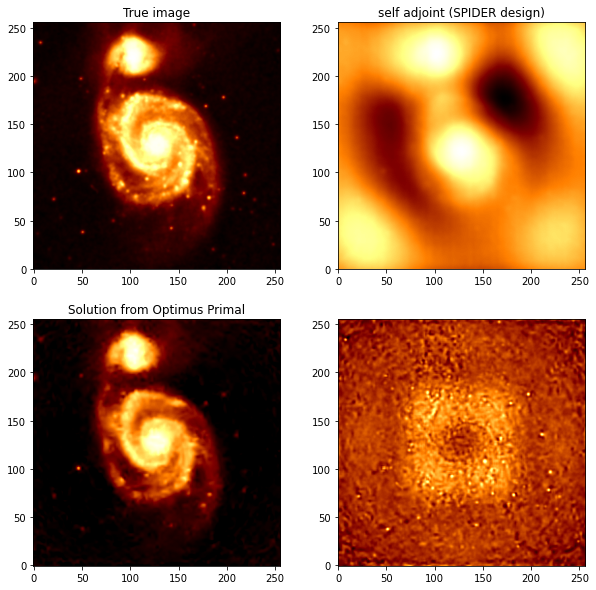

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.adj_op(op_nufft4.dir_op(x_true)).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result.real, **imshow_kwargs)
# ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result2.real))):.4e})")


### Analysing optimisation

Text(0.5, 0, 'iterations')

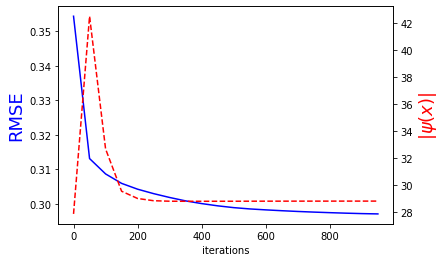

In [11]:
hs = diag2['hs']
xs = np.array(diag2['xs']) 

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

It moves away from the minimum instead of converging. The local minimum looks like this:

Text(0.5, 1.0, 'Residuals (RMSE:2.9711e-01)')

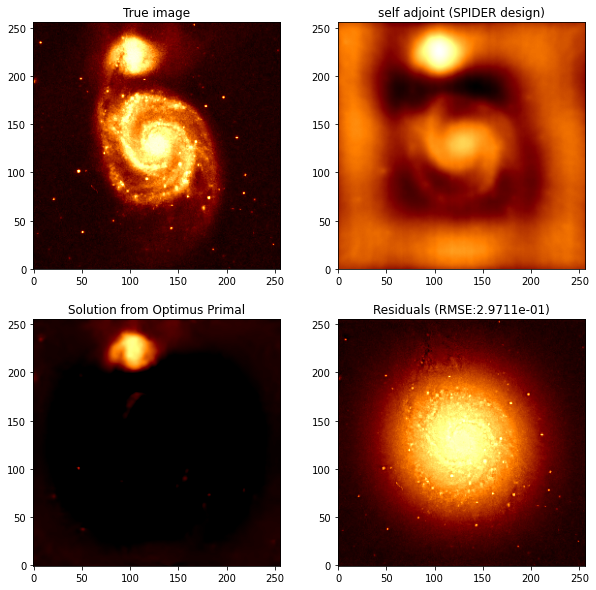

In [12]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

## solving with unconstrained solver

In [13]:
options={'tol': 1e-5, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': False, 'real': False}
result3, diag3 = l1_unconstrained_solver(noisy_y, op_nufft4, sigma, options=options) # solver is hardcoded for n

2021-03-27 14:27:14,154 - Optimus Primal - INFO - Starting Power method
2021-03-27 14:27:14,206 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-27 14:27:14,446 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-27 14:27:14,682 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-27 14:27:14,825 - Optimus Primal - INFO - [Power Method] Converged with norm= 2.868441, iter = 27, tol = 0.000965014
2021-03-27 14:27:14,909 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-27 14:27:15,020 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.007617
2021-03-27 14:27:20,182 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.006760
2021-03-27 14:27:25,380 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.004163
2021-03-27 14:27:30,744 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.002787
2021-03-27 14:27:35,979 - Optimus 

### Results

Text(0.5, 1.0, 'Residuals (RMSE:3.4181e-01)')

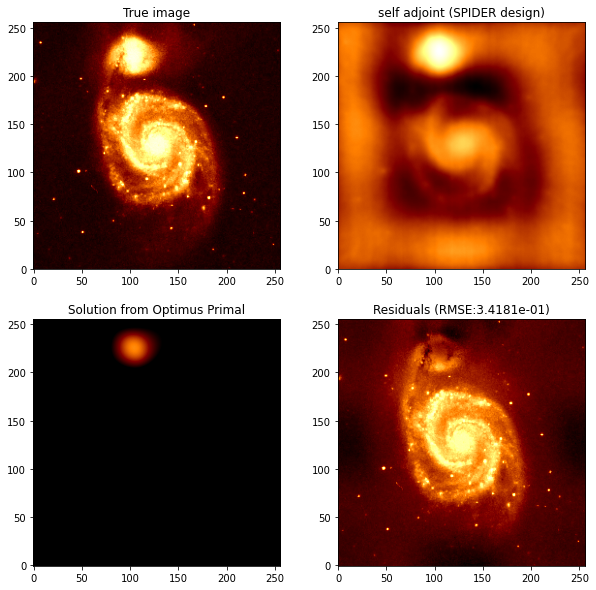

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result3.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result3.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result3.real))):.4e})")

### Analysing optimisation path

Text(0.5, 0, 'iterations')

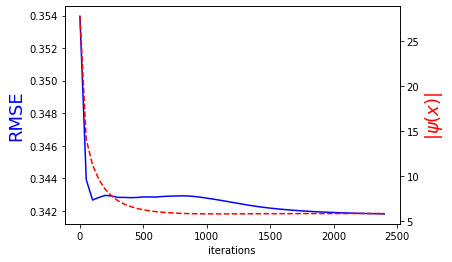

In [15]:
hs = diag3['hs']
xs = np.array(diag3['xs']) 
fs = diag3['fs']

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
# ax.plot(np.arange(0,5000, 50)[:len(fs)], fs, 'b-')

ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

# plt.axis(xmin = 200)

Text(0.5, 1.0, 'Residuals (RMSE:3.4181e-01)')

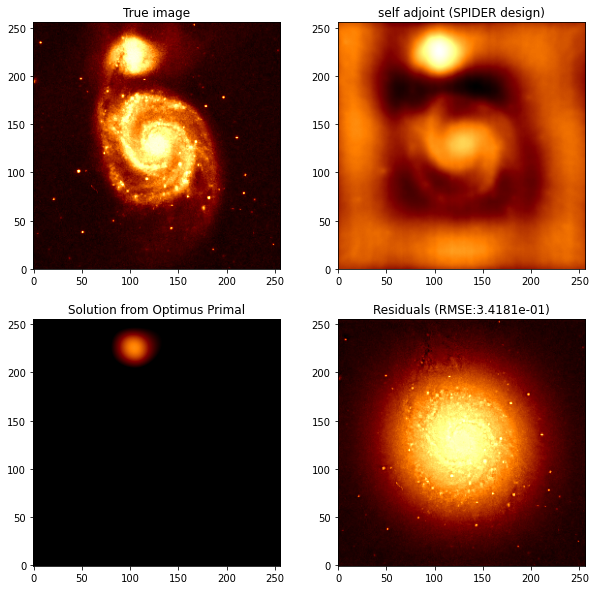

In [16]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

The unconstrained solver doesn't seem to converge to the solution at all. This is probably a problem with scaling the regularisation